<a href="https://colab.research.google.com/github/krithikajain/bart_model_legal_summariser/blob/main/kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score


In [202]:
# loading the data file
data=pd.read_csv('./test.txt', header=None)

In [203]:
# (no_of_images,(28*28)pixels)
data.shape

(10740, 784)

In [204]:
# Normalize each pixel value from range[0,255] to range[0,1]
data =data/255.0

In [205]:
# flattening the pixels into a 1D vector
data = data.values.reshape(data.shape[0],-1)

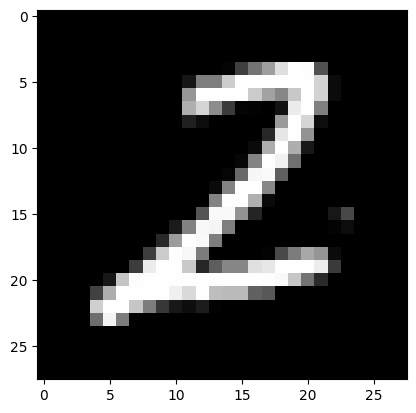

In [206]:
plt.imshow(data[90].reshape(28, 28), cmap='gray');
plt.show()


In [234]:
# dimensionality reduction where 90% data is retained
pca = PCA(n_components=0.9)
train_data = pca.fit_transform(data)

In [235]:
train_data.shape

(10740, 86)

In [187]:
# ms = MinMaxScaler(feature_range=(1,1000))
# scaled_data = ms.fit_transform(reduced_data)

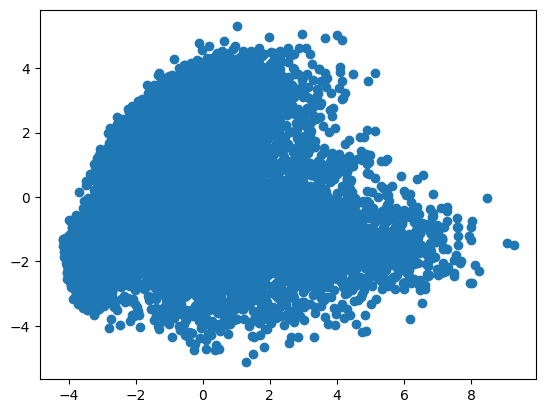

In [188]:
plt.scatter(reduced_data[:,0], reduced_data[:,1])

In [198]:
# train_data = reduced_data

In [241]:
def generateRandomKCentroids(train_data,K):
  random_indices = np.random.choice(train_data.shape[0], K, replace=False)
  centroids = train_data[random_indices, :]
  return centroids

In [242]:
generateRandomKCentroids(train_data,5)

array([[ 1.90650642, -1.02470539,  2.82461535,  2.53140014,  1.22064551,
         0.89742275, -1.93142623, -0.56357283,  0.7321948 ,  0.58413313,
         2.84433004, -1.03409388, -0.01452702, -1.33203201,  1.65627707,
        -1.20040039, -0.96052641,  1.33082352,  0.34538026, -1.11020113,
        -0.28142089, -0.67562835, -1.03739954, -0.75923193, -0.22283071,
         0.92341136,  1.4920765 ,  0.57430913, -0.86743348, -0.16823074,
         0.29689573,  1.6569705 ,  1.26770544, -0.31880304,  0.46552903,
         0.50205438, -0.64863222, -0.5850437 , -0.0488856 , -0.16465013,
        -0.2008035 ,  0.57887691,  0.99037626, -0.58195169, -0.09335854,
         0.08879847, -0.9672483 ,  0.65168279,  0.20222087, -0.08601116,
        -0.54764492, -0.50200102,  0.01828926, -0.40371703,  0.74794156,
        -0.41028986, -0.1690823 ,  0.43344982,  0.04953593,  0.09443424,
        -0.18061461,  0.30929828, -1.13445503, -0.16775748,  0.26783031,
        -0.38045189,  0.35721169,  0.10849945, -0.1

In [247]:
def kmeansCluster(train_data, centroids, max_iterations=100):
  cluster_assigned = np.zeros(train_data.shape[0], dtype=int)
  # centroids = initial_centroids
  for iteration in range(max_iterations):

    for i in range(train_data.shape[0]):
      distances = np.linalg.norm(train_data[i] - centroids, axis=1)
      nearest_k = np.argmin(distances)
      cluster_assigned[i] = nearest_k

    for cluster in range(centroids.shape[0]):
      cluster_points = train_data[cluster_assigned == cluster]
      if len(cluster_points) > 0:
          centroids[cluster] = np.mean(cluster_points, axis=0)
      else:
        random_indices = np.random.choice(train_data.shape[0], 1)
        centroids[cluster] = train_data[random_indices][0]
  return cluster_assigned, centroids

In [248]:
def evaluate_k_means(train_data, K_range):
  silhouette_scores = []

  for K in K_range:
    centroids = generateRandomKCentroids(train_data,K)
    cluster_assigned, final_centroids = kmeansCluster(train_data,centroids)
    silhouette_avg = silhouette_score(train_data, cluster_assigned)
    silhouette_scores.append(silhouette_avg)

  return silhouette_scores

Best K value: 2


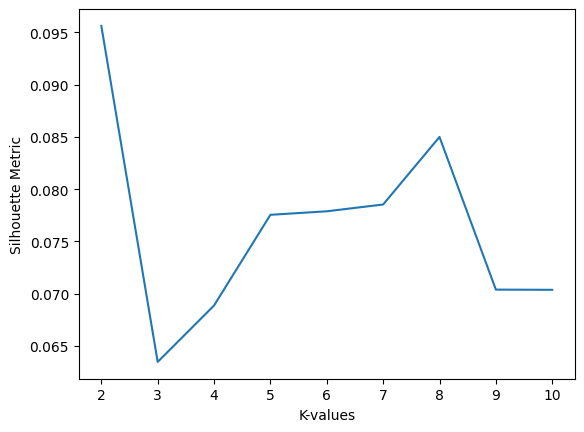

In [250]:
K_range = list(range(2, 11))

# Evaluate clustering for different K values
silhouette_scores = evaluate_k_means(train_data, K_range)

best_K = K_range[np.argmax(silhouette_scores)]
print(f"Best K value: {best_K}")

# Plot the Silhouette Score for different K values
plt.xlabel("K-values")
plt.ylabel("Silhouette Metric")
plt.plot([i for i in K_range], silhouette_scores)
plt.show()